# Appendix E: Two models of uncompensated patch-clamp

Based on the discussion in [Appendix D](./appendix-D-non-ideal-op-amp.ipynb) we now look at models of uncompensated patch clamp, with leak current omitted for simplicity.

<img src="./resources/patch-amp-6-cell-Iin.png" />

We now write an equation for the voltage at every junction, starting bottom left:

\begin{align}
1. && C_m\dot{V}_m = \frac{V_p - V_m}{R_s} - I
\end{align}

where $I$ is the non-capacitative current through the cell membrane.

Next,

\begin{align}
C_p\dot{V}_p = \frac{V_o-V_p}{R_f} + C_f\left(\dot{V}_o-\dot{V}_p\right) - \frac{V_p-V_m}{R_s}
\end{align}

which can be used as a differential equation for either $V_p$

\begin{align}
2. && (C_p + C_f)\dot{V}_p = \frac{V_o-V_p}{R_f} + C_f\dot{V}_o - \frac{V_p-V_m}{R_s}
\end{align}
or $V_o$
\begin{align}
2'. && C_f\dot{V}_o = \frac{V_p-V_o}{R_f} + \left(C_p+C_f\right)\dot{V}_p + \frac{V_p-V_m}{R_s}
\end{align}

Then the bit where the models differ:

\begin{align}
3a. && \tau_a\dot{V}_o = V_c - V_p \\
3b. && \tau_c\dot{V}_p = V_c - V_p \\
\end{align}

where $V_c$ is the command voltage.
The value $\tau_c$ is either a constant (80 nanoseconds) or $\tau_c = \tau_aC_t/C_f$.

And finally

\begin{align}
4. && R_f I_\text{out} \equiv V_\text{out} = V_o - V_p
\end{align}

## Lei et al equations

Equation 1 is equation S2.11 in the supplement and Equation 3b is S2.12.

We can insert equation 4 into equation 2 to get
\begin{align}
\dot{I}_\text{out} 
    = \frac{1}{R_fC_f} \left[C_p\dot{V}_p + \frac{V_p-V_m}{R_s} - I_\text{out} \right]
    = \frac{I_\text{in} - I_\text{out}}{R_fC_f}
\end{align}

where
\begin{align}
I_\text{in} 
    = C_p\dot{V}_p + \frac{V_p-V_m}{R_s}
    = C_p\dot{V}_p + C_m\dot{V}_m + I
\end{align}

which are equations S2.8 and S2.5.

So the B model above is equivalent to the Lei et al. model (without leak, offset, or compensations).

## Simulations

We now run simulations for a single step from -80 to -20 mV.
The ionic current is set to 0.

The values for the different constants are mostly based on Weerakoon.
We recalculate $\tau_c$ instead of using the constant value.
The value for $\tau_a$ is the 50ns from Weerakoon et al., slower than the 16ns used in Sigworth 1995.

### Lei et al., original formulation

In [2]:
import myokit

import numpy as np
import matplotlib.pyplot as plt

In [3]:
m0 = myokit.parse_model('''
[[model]]
cell.Vm = -80  # Vm starts at -80
amp.Vp = -80   # I=0, dot(Vm)=0, so Vp = Vm
amp.I_out = 0  # I=0, steady state

[engine]
time = 0 [ms]
    in [ms]
    bind time

[cell]
use amp.Rs, amp.Vp
Cm = 100 [pF]
    in [pF]
I = 0 [pA]
    in [pA]

# Equation 1 / Equation S2.11
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]

[amp]
use cell.Vm, cell.Cm
Vc = -20 [mV]
    in [mV]
Rs = 0.01 [GOhm]
    in [GOhm]
Rf = 0.025 [GOhm]
    in [GOhm]
Cf = 0.3 [pF]
    in [pF]
Cp = 4.5 [pF]  # Value chosen to get tau_c = 0.8 as in Weerakoon
    in [pF]
Ct = Cf + Cp
    in [pF]
tau_amp = 0.05e-3 [ms]
    in [ms]
tau_c = tau_amp * (Cf + Cp) / Cf
    in [ms]

# Equation S2.5
I_in = cell.I + Cm * dot(Vm) + Cp * dot(Vp)
    in [pA]

# Equation S2.8
dot(I_out) = (I_in - I_out) / (Rf * Cf)
    in [pA]

# Equation 3b, S2.12
dot(Vp) = (Vc - Vp) / tau_c
    in [mV]

''')
m0.check_units(myokit.UNIT_STRICT)

print(f'Tau c: {m0.get("amp.tau_c").eval() * 1e3} us')

Tau c: 0.8 us


In [4]:
s0 = myokit.Simulation(m0)
d0 = s0.run(10)

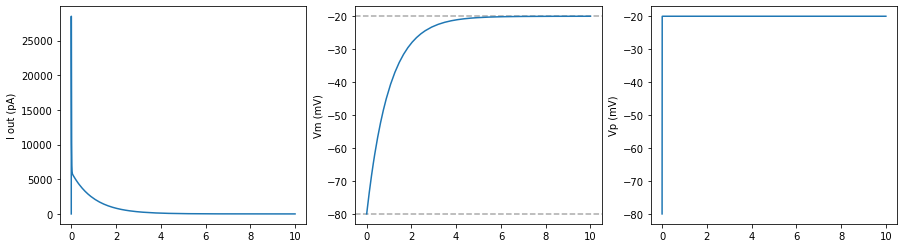

In [5]:
kw = dict(color='#aaa', ls='--')

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1); ax.set_ylabel('I out (pA)')
ax.plot(d0.time(), d0['amp.I_out'])
ax = fig.add_subplot(1, 3, 2); ax.set_ylabel('Vm (mV)')
ax.axhline(m0.get('cell.Vm').initial_value().eval(), **kw)
ax.axhline(m0.get('amp.Vc').eval(), **kw)
ax.plot(d0.time(), d0['cell.Vm'])
ax = fig.add_subplot(1, 3, 3); ax.set_ylabel('Vp (mV)')
ax.plot(d0.time(), d0['amp.Vp'])
plt.show()

### Lei et al. reformulation

In [6]:
m1 = myokit.parse_model('''
[[model]]
cell.Vm = -80  # Vm starts at -80
amp.Vp = -80   # I=0, dot(Vm)=0, so Vp = Vm
amp.Vo = -80   # ?

[engine]
time = 0 [ms]
    in [ms]
    bind time

[cell]
use amp.Rs, amp.Vp
Cm = 100 [pF]
    in [pF]
I = 0 [pA]
    in [pA]

# Equation 1
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]

[amp]
use cell.Vm
Vc = -20 [mV]
    in [mV]
Rs = 0.01 [GOhm]
    in [GOhm]
Rf = 0.025 [GOhm]
    in [GOhm]
Cf = 0.3 [pF]
    in [pF]
Cp = 4.5 [pF]  # Value chosen to get tau_c = 0.8 as in Weerakoon
    in [pF]
Ct = Cf + Cp
    in [pF]
tau_amp = 0.05e-3 [ms]
    in [ms]
tau_c = tau_amp * (Cf + Cp) / Cf
    in [ms]

# Equation 2'
dot(Vo) = (Vp - Vo) / (Rf * Cf) + (Cp + Cf) / Cf * dot(Vp) + (Vp - Vm) / (Rs * Cf)
    in [mV]

# Equation 3b
dot(Vp) = (Vc - Vp) / tau_c
    in [mV]

# Equation 4
I_out = (Vo - Vp) / Rf
    in [pA]

''')
m1.check_units(myokit.UNIT_STRICT)

In [7]:
s1 = myokit.Simulation(m1)
d1 = s1.run(10)

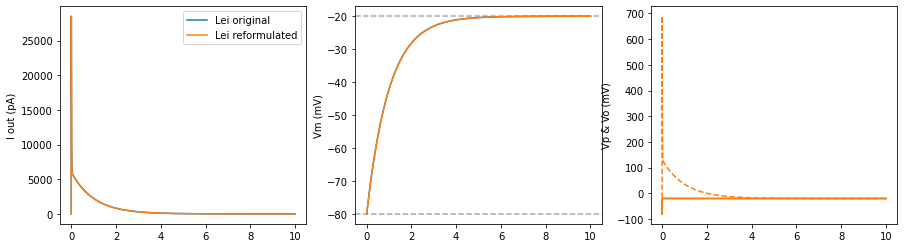

In [8]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1); ax.set_ylabel('I out (pA)')
ax.plot(d0.time(), d0['amp.I_out'], label='Lei original')
ax.plot(d1.time(), d1['amp.I_out'], label='Lei reformulated')
ax.legend()
ax = fig.add_subplot(1, 3, 2); ax.set_ylabel('Vm (mV)')
ax.axhline(m0.get('cell.Vm').initial_value().eval(), **kw)
ax.axhline(m0.get('amp.Vc').eval(), **kw)
ax.plot(d0.time(), d0['cell.Vm'])
ax.plot(d1.time(), d1['cell.Vm'])
ax = fig.add_subplot(1, 3, 3); ax.set_ylabel('Vp & Vo (mV)')
ax.plot(d0.time(), d0['amp.Vp'])
ax.plot(d1.time(), d1['amp.Vp'])
ax.plot(d1.time(), d1['amp.Vo'], '--', color='tab:orange')
plt.show()

### New model

In [9]:
m2 = myokit.parse_model('''
[[model]]
cell.Vm = -80  # Vm starts at -80
amp.Vp = -80   # I=0, dot(Vm)=0, so Vp = Vm
amp.Vo = -80   # ?

[engine]
time = 0 [ms]
    in [ms]
    bind time

[cell]
use amp.Rs, amp.Vp
Cm = 100 [pF]
    in [pF]
I = 0 [pA]
    in [pA]

# Equation 1
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm
    in [mV]

[amp]
use cell.Vm
Vc = -20 [mV]
    in [mV]
Rs = 0.01 [GOhm]
    in [GOhm]
Rf = 0.025 [GOhm]
    in [GOhm]
Cf = 0.3 [pF]
    in [pF]
Cp = 4.5 [pF]  # Value chosen to get tau_c = 0.8 as in Weerakoon
    in [pF]
Ct = Cf + Cp
    in [pF]
tau_amp = 0.05e-3 [ms]
    in [ms]
#tau_c = tau_amp * (Cf + Cp) / Cf
#    in [ms]

# Equation 2
dot(Vp) = (Vo - Vp) / (Rf * Ct) + Cf / Ct * dot(Vo) - (Vp - Vm) / (Rs * Ct)
    in [mV]

# Equation 3a
dot(Vo) = (Vc - Vp) / tau_amp
    in [mV]

# Equation 4
I_out = (Vo - Vp) / Rf
    in [pA]

''')
m2.check_units(myokit.UNIT_STRICT)

In [10]:
s2 = myokit.Simulation(m2)
d2 = s2.run(10)

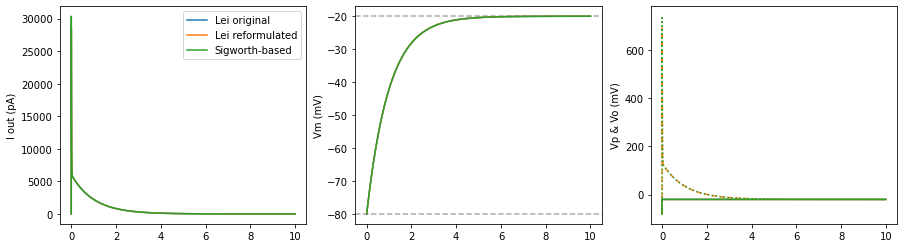

In [11]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1); ax.set_ylabel('I out (pA)')
ax.plot(d0.time(), d0['amp.I_out'], label='Lei original')
ax.plot(d1.time(), d1['amp.I_out'], label='Lei reformulated')
ax.plot(d2.time(), d2['amp.I_out'], label='Sigworth-based')
ax.legend()
ax = fig.add_subplot(1, 3, 2); ax.set_ylabel('Vm (mV)')
ax.axhline(m0.get('cell.Vm').initial_value().eval(), **kw)
ax.axhline(m0.get('amp.Vc').eval(), **kw)
ax.plot(d0.time(), d0['cell.Vm'])
ax.plot(d1.time(), d1['cell.Vm'])
ax.plot(d2.time(), d2['cell.Vm'])
ax = fig.add_subplot(1, 3, 3); ax.set_ylabel('Vp & Vo (mV)')
ax.plot(d0.time(), d0['amp.Vp'])
ax.plot(d1.time(), d1['amp.Vp'])
ax.plot(d1.time(), d1['amp.Vo'], '--', color='tab:orange')
ax.plot(d2.time(), d2['amp.Vp'])
ax.plot(d2.time(), d2['amp.Vo'], ':', color='tab:green')
plt.show()

### Slow amp

The traces look extremely similar, because they are dominated by the membrane charging time.

We can make the difference visible by slowing down the op amp:

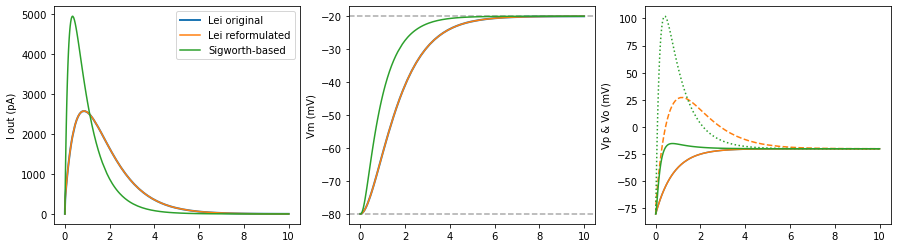

In [12]:
new_tau_amp = 0.05  # 1000 times larger
s0.set_constant('amp.tau_amp', new_tau_amp)
s1.set_constant('amp.tau_amp', new_tau_amp)
s2.set_constant('amp.tau_amp', new_tau_amp)
s0.reset()
s1.reset()
s2.reset()
d0 = s0.run(10)
d1 = s1.run(10)
d2 = s2.run(10)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1); ax.set_ylabel('I out (pA)')
ax.plot(d0.time(), d0['amp.I_out'], label='Lei original', lw=2)
ax.plot(d1.time(), d1['amp.I_out'], label='Lei reformulated')
ax.plot(d2.time(), d2['amp.I_out'], label='Sigworth-based')
ax.legend()
ax = fig.add_subplot(1, 3, 2); ax.set_ylabel('Vm (mV)')
ax.axhline(m0.get('cell.Vm').initial_value().eval(), **kw)
ax.axhline(m0.get('amp.Vc').eval(), **kw)
ax.plot(d0.time(), d0['cell.Vm'], lw=2)
ax.plot(d1.time(), d1['cell.Vm'])
ax.plot(d2.time(), d2['cell.Vm'])
ax = fig.add_subplot(1, 3, 3); ax.set_ylabel('Vp & Vo (mV)')
ax.plot(d0.time(), d0['amp.Vp'])
ax.plot(d1.time(), d1['amp.Vp'])
ax.plot(d1.time(), d1['amp.Vo'], '--', color='tab:orange')
ax.plot(d2.time(), d2['amp.Vp'])
ax.plot(d2.time(), d2['amp.Vo'], ':', color='tab:green')
plt.show()

### Unstable amp

We can calculate the damping factor as

\begin{align}
\zeta = \frac{\tau_a + R_fC_f}{\sqrt{\tau_a R_f (C_p+C_f)}}
\end{align}

In [13]:
Rf = 0.025 # GOhm
Cf = 0.3 # pF
Cp = 4.5 # pF, pF * GOhm = ms
tau_amp = 0.05e-3 # ms

zeta = (tau_amp + Rf*Cf) / np.sqrt(tau_amp * Rf * (Cf + Cp))
# (ms + ms) / sqrt(ms * ms) = dimensionless

print(f'Zeta: {zeta}')

Zeta: 3.082274593002165


If we had a very small $C_f$ we could get some ringing, but as this is set by the amplifier design it might be more feasible that we had a very large $C_p$:

In [14]:
Cp *= 20
zeta = (tau_amp + Rf*Cf) / np.sqrt(tau_amp * Rf * (Cf + Cp))
print(f'Zeta: {zeta}')

Zeta: 0.7106374160558676


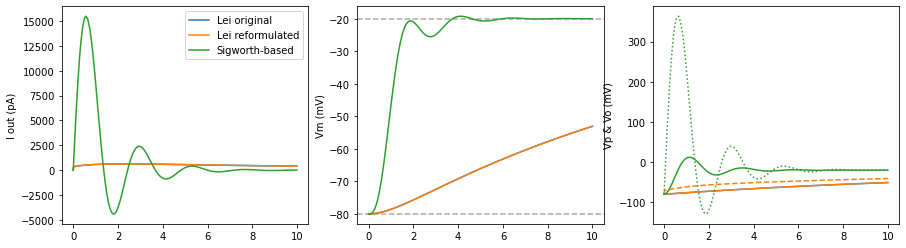

In [15]:
new_Cp = 4.5 * 20
s0.set_constant('amp.Cp', new_Cp)
s1.set_constant('amp.Cp', new_Cp)
s2.set_constant('amp.Cp', new_Cp)
s0.reset()
s1.reset()
s2.reset()
d0 = s0.run(10)
d1 = s1.run(10)
d2 = s2.run(10)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1); ax.set_ylabel('I out (pA)')
ax.plot(d0.time(), d0['amp.I_out'], label='Lei original')
ax.plot(d1.time(), d1['amp.I_out'], label='Lei reformulated')
ax.plot(d2.time(), d2['amp.I_out'], label='Sigworth-based')
ax.legend()
ax = fig.add_subplot(1, 3, 2); ax.set_ylabel('Vm (mV)')
ax.axhline(m0.get('cell.Vm').initial_value().eval(), **kw)
ax.axhline(m0.get('amp.Vc').eval(), **kw)
ax.plot(d0.time(), d0['cell.Vm'])
ax.plot(d1.time(), d1['cell.Vm'])
ax.plot(d2.time(), d2['cell.Vm'])
ax = fig.add_subplot(1, 3, 3); ax.set_ylabel('Vp & Vo (mV)')
ax.plot(d0.time(), d0['amp.Vp'])
ax.plot(d1.time(), d1['amp.Vp'])
ax.plot(d1.time(), d1['amp.Vo'], '--', color='tab:orange')
ax.plot(d2.time(), d2['amp.Vp'])
ax.plot(d2.time(), d2['amp.Vo'], ':', color='tab:green')
plt.show()

Here the Sigworth-based model shows ringing, but the Weerakoon/Lei model does not (cannot?).

Of course, this is still with a slowed down amp.
We can restore its original value:

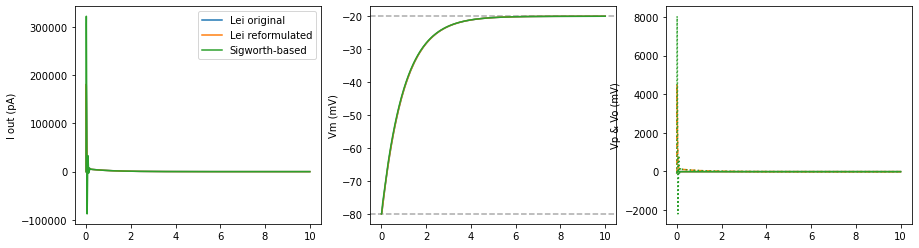

In [16]:
old_tau_amp = 0.05e-3  # Original value
s0.set_constant('amp.tau_amp', old_tau_amp)
s1.set_constant('amp.tau_amp', old_tau_amp)
s2.set_constant('amp.tau_amp', old_tau_amp)
s0.reset()
s1.reset()
s2.reset()
d0 = s0.run(10)
d1 = s1.run(10)
d2 = s2.run(10)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1); ax.set_ylabel('I out (pA)')
ax.plot(d0.time(), d0['amp.I_out'], label='Lei original')
ax.plot(d1.time(), d1['amp.I_out'], label='Lei reformulated')
ax.plot(d2.time(), d2['amp.I_out'], label='Sigworth-based')
ax.legend()
ax = fig.add_subplot(1, 3, 2); ax.set_ylabel('Vm (mV)')
ax.axhline(m0.get('cell.Vm').initial_value().eval(), **kw)
ax.axhline(m0.get('amp.Vc').eval(), **kw)
ax.plot(d0.time(), d0['cell.Vm'])
ax.plot(d1.time(), d1['cell.Vm'])
ax.plot(d2.time(), d2['cell.Vm'])
ax = fig.add_subplot(1, 3, 3); ax.set_ylabel('Vp & Vo (mV)')
ax.plot(d0.time(), d0['amp.Vp'])
ax.plot(d1.time(), d1['amp.Vp'])
ax.plot(d1.time(), d1['amp.Vo'], '--', color='tab:orange')
ax.plot(d2.time(), d2['amp.Vp'])
ax.plot(d2.time(), d2['amp.Vo'], ':', color='tab:green')
plt.show()

So for an underdamped system we can see a difference between the two!

Let's zoom in a bit:

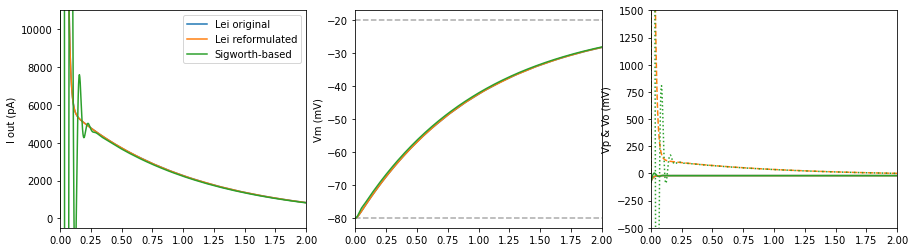

In [17]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1); ax.set_ylabel('I out (pA)')
ax.plot(d0.time(), d0['amp.I_out'], label='Lei original')
ax.plot(d1.time(), d1['amp.I_out'], label='Lei reformulated')
ax.plot(d2.time(), d2['amp.I_out'], label='Sigworth-based')
ax.set_xlim(0, 2)
ax.set_ylim(-500, 11000)
ax.legend()
ax = fig.add_subplot(1, 3, 2); ax.set_ylabel('Vm (mV)')
ax.axhline(m0.get('cell.Vm').initial_value().eval(), **kw)
ax.axhline(m0.get('amp.Vc').eval(), **kw)
ax.plot(d0.time(), d0['cell.Vm'])
ax.plot(d1.time(), d1['cell.Vm'])
ax.plot(d2.time(), d2['cell.Vm'])
ax.set_xlim(0, 2)
ax = fig.add_subplot(1, 3, 3); ax.set_ylabel('Vp & Vo (mV)')
ax.plot(d0.time(), d0['amp.Vp'])
ax.plot(d1.time(), d1['amp.Vp'])
ax.plot(d1.time(), d1['amp.Vo'], '--', color='tab:orange')
ax.plot(d2.time(), d2['amp.Vp'])
ax.plot(d2.time(), d2['amp.Vo'], ':', color='tab:green')
ax.set_xlim(0, 2)
ax.set_ylim(-500, 1500)
plt.show()

## Conclusion?

- Starting from the Sigworth 1995 equation for the op amp instead of Weerakoon et al., we get a system with a faster step response, but this is invisible in the normal traces, which are dominated by the membrane charging time.
- When $C_p$ becomes so large that the system becomes underdamped, we can see a difference between the models (Sigworth version shows "ringing").

For "normal" patch clamp experiments I have no fundamental reason to prefer one over the other. (1) I can't find a reference that uses the same equation as Sigworth and (2) The Weerakoon equation is perhaps a simpler "first approximation", so more parsimonious? But (3) the Weerakoon equation uses a $\tau_c$ derived from the Sigworth analysis and.